<a href="https://colab.research.google.com/github/mridulanaik/R2-lab-external-stat/blob/master/CNN_Project_2_Dog_Breed_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dog Breed Classification

In this project we will use traditional CNN, CNN with data augmentation and finally transfer Learning by VGG16 model with weights pre-trained on Imagenet to solve the dog breed classification problem

### Load Dataset Files

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
from tqdm import tqdm
import seaborn as sns
from keras.preprocessing import image
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
from PIL import Image
import sklearn as sklearn
from sklearn.metrics import confusion_matrix
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier as MLPC
from sklearn import model_selection
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras import initializers, layers, models
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from keras.utils.vis_utils import plot_model
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs
from os.path import join, exists, expanduser
from sklearn.metrics import log_loss, accuracy_score
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications import xception
from keras.applications import inception_v3
from keras.applications.vgg16 import preprocess_input, decode_predictions
import datetime as dt
start = dt.datetime.now()
%matplotlib inline

Using TensorFlow backend.


Now, upload the given dataset file shared with you in your google drive and give its path for the below given `project_path` variable. For example, a path is given below according to the file path in our google drive. You need to change this to match the path of yours.

In [0]:
project_path = "/content/drive/My Drive/Colab Notebooks/CNN_Project_1/"

Run the below code to extract all the images in the train.zip files given in the dataset. We are going to use these images as train and validation sets and their labels in further steps.

In [0]:
from zipfile import ZipFile
with ZipFile("/content/drive/My Drive/DogBreed_Classification/"+'train.zip', 'r') as z:
  z.extractall()

Repeat the same step for test.zip

In [0]:
from zipfile import ZipFile
with ZipFile("/content/drive/My Drive/DogBreed_Classification/"+'test.zip', 'r') as z:
  z.extractall()

Repeat the same step for sample_submission.csv.zip

In [0]:
from zipfile import ZipFile
with ZipFile("/content/drive/My Drive/DogBreed_Classification/sample_submission.csv.zip", 'r') as z:
  z.extractall()

Repeat the same step for labels.csv.zip

In [0]:
from zipfile import ZipFile
with ZipFile("/content/drive/My Drive/DogBreed_Classification/labels.csv.zip", 'r') as z:
  z.extractall()

After this process, we will have 4 files - Train folder, test folder and labels.csv and sample_submission.csv as part of your google drive

### Read labels.csv file using pandas

In [0]:
labels = pd.read_csv('labels.csv')

In [10]:
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


### Print the count of each category of Dogs given in the dataset



In [11]:
labels.breed.value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
komondor                 67
brabancon_griffon        67
golden_retriever         67
briard                   66
eskimo_dog               66
Name: breed, Length: 120, dtype: int64

### Get one-hot encodings of labels

In [0]:
targets_series = pd.Series(labels['breed'])
one_hot = pd.get_dummies(targets_series, sparse = True)
one_hot_labels = np.asarray(one_hot)

In [0]:
one_hot_labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

## Preparing training dataset
1. Write a code which reads each and every id from labels.csv file and loads the corresponding image (in RGB - 128, 128, 3) from the train folder. <br>
2. Create 2 variables <br> 
     a.  x_train - Should have all the images of the dogs from train folder <br>
     b.  y_train - Corresponding label of the dog <br>
<u>Note:</u> The id of the dog images and its corresponding labels are available in labels.csv file   
<u>Hint:</u> Watch the video shared on "Preparing the training dataset" if you face issue on creating the training dataset

In [13]:
im_size = 128
x_train = []
y_train = []
i = 0 

for f, breed in tqdm(labels.values):
    img = cv2.imread('train/{}.jpg'.format(f), 1)
    label = one_hot_labels[i]
    x_train.append(cv2.resize(img, (im_size, im_size)))
    y_train.append(label)
    i += 1


y_train_raw = np.array(y_train, np.uint8)
x_train_raw = np.array(x_train, np.float32) / 255.

num_class = y_train_raw.shape[1]

print(x_train_raw.shape)
print(y_train_raw.shape)

100%|██████████| 10222/10222 [00:28<00:00, 352.62it/s]


(10222, 128, 128, 3)
(10222, 120)


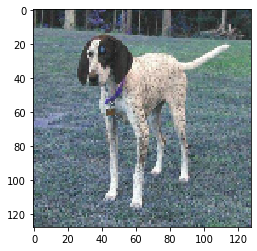

In [14]:
plt.imshow(x_train[3])

Normalize the training data and convert into 4 dimensions so that it can be used as an input to conv layers in the model

### Split the training and validation data from `x_train_data` and `y_train_data` obtained from above step

In [0]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train_raw, y_train_raw, test_size=0.3, random_state=1)

In [16]:
np.array(x_valid).shape

(3067, 128, 128, 3)

### Loading the test data
Read the id column from the samples_submission.csv and store it in test_img

In [0]:
test_img = pd.read_csv('sample_submission.csv')

Run the below code to load the test image files in x_test_feature

In [18]:
x_test_feature = []
i = 0 # initialisation
# for f in tqdm(test_img.values): # f for format ,jpg
#     img = cv2.imread('test/{}.jpg'.format(f), 0)
#     img_resize = cv2.resize(img, (im_size, im_size)) 
#     x_test_feature.append(img_resize)

for f in tqdm(test_img['id'].values):
    img = cv2.imread('test/{}.jpg'.format(f))
    x_test_feature.append(cv2.resize(img, (im_size, im_size), 1))

100%|██████████| 10357/10357 [00:28<00:00, 358.76it/s]


Normalize the test data and convert it into 4 dimensions

In [19]:
x_testContest  = np.array(x_test_feature, np.float32) / 255.
x_testContest.shape

(10357, 128, 128, 3)

### Build a basic conv neural network with 2 conv layers (kernel sizes - 5 and 3) add layers as mentioned below for classification.

1. Add a Dense layer with 256 neurons with `relu` activation

2. Add a Dense layer with 120 neurons as final layer (as there are 120 classes in the given dataset) with `softmax` activation for classifiaction. 

In [20]:
# Define model
model = Sequential()

# 1st Conv Layer
model.add(Conv2D(32, (5, 5), input_shape=(128, 128, 3)))
model.add(Activation('relu'))

# 2nd Conv Layer
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))

# Fully Connected Layer
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

# Prediction Layer
model.add(Dense(120))
model.add(Activation('softmax'))

# Loss and Optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Use batch_size = 128 and epochs = 10 and execute the model

In [21]:
# Train the model
    model.fit(x_train, y_train, batch_size = 128, epochs = 10, 
              validation_data=(x_valid, y_valid))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 7155 samples, validate on 3067 samples
Epoch 1/10





7155/7155 [==============================] - 30s 4ms/step - loss: 6.2820 - acc: 0.0096 - val_loss: 4.7868 - val_acc: 0.0052
Epoch 2/10
7155/7155 [==============================] - 11s 2ms/step - loss: 4.7702 - acc: 0.0158 - val_loss: 4.7660 - val_acc: 0.0140
Epoch 3/10
7155/7155 [==============================] - 11s 2ms/step - loss: 4.5233 - acc: 0.0569 - val_loss: 4.7234 - val_acc: 0.0225
Epoch 4/10
7155/7155 [==============================] - 11s 2ms/step - loss: 3.3382 - acc: 0.2527 - val_loss: 5.4163 - val_acc: 0.0245
Epoch 5/10
7155/7155 [==============================] - 11s 2ms/step - loss: 1.3755 - acc: 0.6734 - val_loss: 7.4691 - val_acc: 0.0245
Epoch 6/10
7155/7155 [==============================] - 11s 2ms/step - loss: 0.2932 - acc: 0.9399 - val_loss: 10.1578 - val_acc: 0.0241
Epoch 7/10
7155/7155 [=================

#The model accuracy is very poor !!!!

### Use Data Augmentation in the above model to see if the accuracy improves


In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
batch_size = 20
epochs = 10

# this is the augmentation configuration we will use for training
# This will do preprocessing and realtime data augmentation:
train_datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=50,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images


In [0]:
# the validation images will be left unchanged
test_datagen = ImageDataGenerator()

### Using the above objects, create the image generators with variable names `train_generator` and `val_generator`

You need to use train_datagen.flow() and val_datagen.flow()

In [0]:
# this is the augmentation configuration we will use for training:
train_generator = train_datagen.flow(
        x_train,
        y_train,
        batch_size=batch_size)  
# this is the augmentation configuration we will use for validation:
validation_generator = test_datagen.flow(
        x_valid,
        y_valid,
        batch_size=batch_size)

### Fit the model using fit_generator() using `train_generator` and `val_generator` from the above step with 10 epochs

In [0]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_acc', patience=7, verbose=1, mode='auto')
callback_list = [early_stopping]

In [27]:
model.fit_generator(
        train_generator,
        epochs=epochs,
        validation_data = validation_generator,
        callbacks= callback_list,
        verbose=1)

Epoch 1/10
358/358 [==============================] - 42s 117ms/step - loss: 4.8455 - acc: 0.0090 - val_loss: 4.7821 - val_acc: 0.0137
Epoch 2/10
358/358 [==============================] - 41s 115ms/step - loss: 4.7779 - acc: 0.0130 - val_loss: 4.7783 - val_acc: 0.0150
Epoch 3/10
358/358 [==============================] - 41s 115ms/step - loss: 4.7723 - acc: 0.0127 - val_loss: 4.8421 - val_acc: 0.0202
Epoch 4/10
358/358 [==============================] - 41s 115ms/step - loss: 4.7601 - acc: 0.0144 - val_loss: 4.7635 - val_acc: 0.0183
Epoch 5/10
358/358 [==============================] - 41s 114ms/step - loss: 4.7466 - acc: 0.0135 - val_loss: 4.7593 - val_acc: 0.0205
Epoch 6/10
358/358 [==============================] - 42s 116ms/step - loss: 4.7290 - acc: 0.0156 - val_loss: 4.6848 - val_acc: 0.0218
Epoch 7/10
358/358 [==============================] - 42s 117ms/step - loss: 4.6925 - acc: 0.0173 - val_loss: 4.6340 - val_acc: 0.0277
Epoch 8/10
358/358 [==============================] - 4

# Model accuracy is still poor!!!

### Lets use Transfer Learning

Download the vgg wieght file from here : https://github.com/MinerKasch/applied_deep_learning/blob/master/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5

Use the below code to load VGG16 weights trained on ImageNet

In [0]:
from keras import applications
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Input
# Instantiate the model with the pre-trained weights (no top)
# base_model= VGG16(weights=(project_path+'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'),
#                   include_top=False, pooling='avg', input_tensor = Input(shape=(128,128,3)))
base_model = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (128, 128, 3))


Print the summary of the base_model

In [30]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

### Add the following classification layers to the imported VGG Model <br>
1. Flatten Layer
2. Dense layer with 1024 neurons with activation as Relu
3. Dense layer with 256 neurons with activation as Relu
4. Dense layer with 120 neurons with activation as Softmax

In [0]:
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dense(256, activation="relu")(x)
predictions = Dense(120, activation="softmax")(x)

### Make all the layers in the base_model (VGG16) to be non-trainable

In [0]:
# Freeze the layers which you don't want to train.
for layer in base_model.layers[:]:
    layer.trainable = False

### Fit and compile the model with batch_size = 128 and epochs = 10 and execute the model

Try to get training and validation accuracy to be more than 90%

In [35]:
from keras import applications
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers

# creating the final model 
model_final = Model(input = base_model.input, output = predictions)

# compile the model 
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_final.compile(loss = "categorical_crossentropy", optimizer = 'rmsprop', metrics=["accuracy"])


# Save the model 
checkpoint = ModelCheckpoint("vgg16_best.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1, mode='auto')

epochs=10
# Train the model 
model_final.fit(x_train, y_train, batch_size = 128, epochs = epochs, validation_data=(x_valid, y_valid), callbacks = [checkpoint, early])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if __name__ == '__main__':


Train on 7155 samples, validate on 3067 samples
Epoch 1/10
7155/7155 [==============================] - 16s 2ms/step - loss: 1.1553 - acc: 0.7434 - val_loss: 4.0605 - val_acc: 0.1986

Epoch 00001: val_acc improved from -inf to 0.19857, saving model to vgg16_best.h5
Epoch 2/10
7155/7155 [==============================] - 16s 2ms/step - loss: 0.6396 - acc: 0.8347 - val_loss: 4.4748 - val_acc: 0.1865

Epoch 00002: val_acc did not improve from 0.19857
Epoch 3/10
7155/7155 [==============================] - 16s 2ms/step - loss: 0.4833 - acc: 0.8816 - val_loss: 4.5777 - val_acc: 0.2005

Epoch 00003: val_acc improved from 0.19857 to 0.20052, saving model to vgg16_best.h5
Epoch 4/10
7155/7155 [==============================] - 16s 2ms/step - loss: 0.3826 - acc: 0.9103 - val_loss: 4.7336 - val_acc: 0.1947

Epoch 00004: val_acc did not improve from 0.20052
Epoch 5/10
7155/7155 [==============================] - 16s 2ms/step - loss: 0.3637 - acc: 0.9168 - val_loss: 4.3823 - val_acc: 0.2292

Epoch